In [1]:
import pandas as pd
import numpy as np
import json
import os
import seaborn as sbn
import matplotlib.pyplot as plt
import seaborn as sns

#import bokeh.palettes

plt.rcParams['svg.fonttype'] = 'none'

sns.set_context("paper")
sns.set_style("white")

# Mutation data process rules

1. If a INS or SNP mutation occured in an intergenic region between two genes, find the closest gene and increase the count of only the closest gene. 

2. If multiple genes are deleted, increase the counts of all the genes



In [2]:
gene_table = pd.read_csv("../Data/gene_info_GenBank.csv", index_col=0)  # Unique to this NB
gene_table.gene_name=gene_table.gene_name.str.replace('-','')

In [3]:
gene_table

,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon
locus_tag,,,,,,,,,,
b0001,thrL,NC_000913.3,NaN,190,255,+,thr operon leader peptide,No COG annotation,P0AD86,Op0
b0002,thrA,NC_000913.3,NaN,337,2799,+,fused aspartate kinase/homoserine dehydrogenase 1,Amino acid transport and metabolism,P00561,Op0
b0003,thrB,NC_000913.3,NaN,2801,3733,+,homoserine kinase,Nucleotide transport and metabolism,P00547,Op0
b0004,thrC,NC_000913.3,NaN,3734,5020,+,threonine synthase,Amino acid transport and metabolism,P00934,Op0
b0005,yaaX,NC_000913.3,NaN,5234,5530,+,DUF2502 domain-containing protein YaaX,Function unknown,P75616,Op1
...,...,...,...,...,...,...,...,...,...,...
b4399,creC,NC_000913.3,NaN,4636696,4638120,+,sensory histidine kinase CreC,Signal transduction mechanisms,P08401,Op2427
b4400,creD,NC_000913.3,NaN,4638178,4639530,+,putative inner membrane protein CreD,Defense mechanisms,P08369,Op2427
b4401,arcA,NC_000913.3,NaN,4639590,4640306,-,DNA-binding transcriptional dual regulator ArcA,Transcription,P0A9Q1,Op2428


#Manually added gene name

b1522 dgcF -> YneF
b0022 insA1 -> insA
b1917 tcyN -> yecC
b1918 -> yecS

b1920 -> fliY
b1934 newly added

b1956 ydeQ
yedS

b2092 gatC
b2352 -> gtrS


b3423 glpR



In [4]:
mut_df = pd.read_csv("../Data/Mutation_data/mutation_data_hgl.tsv", sep='\t')  # Unique to this NB

In [5]:
mut_df=mut_df.fillna(0)

In [6]:
mut_df

,ReferenceSeq,Position,MutationType,Gene,Details,12PD_A1_F50_I1_R1,12PD_A1_F50_I2_R1,12PD_A1_F50_I3_R1,12PD_A2_F50_I1_R1,12PD_A2_F50_I2_R1,...,GLUC_A7_F88_I2_R1,GLUC_A8_F380_I1_R1,GLUC_A8_F380_I2_R1,GLUC_A8_F380_I3_R1,GLUC_A9_F433_I1_R1,GLUC_A9_F433_I2_R1,GLUC_A9_F433_I3_R1,GLUC_A10_F418_I1_R1,GLUC_A10_F418_I2_R1,GLUC_A10_F418_I3_R1
0,NC_000913,2374,SNP,thrA,A680S(GCG_TCG),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NC_000913,7361,SNP,yaaJ,V200A(GTC_GCC),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NC_000913,7618,SNP,yaaJ,Q114H(CAA_CAC),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NC_000913,10463,SNP,satP,P11L(CCG_CTG),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NC_000913,11664,SNP,yaaI,D41E(GAT_GAG),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3463,NC_000913,4184543,SNP,rpoB,P1100Q(CCG_CAG),0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3464,NC_000913,4189493,DEL,rpoC,coding(4144-4160/4224nt),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3465,NC_000913,4296381,INS,"gltP, yjcO",intergenic(+587/+55),0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3466,NC_000913,4510524,SNP,"yjhV, fecE",intergenic(+391/+166),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


# Process intergenic region


In [7]:
#Determine which gene out of the two neighboring genes is the closer to the mutation location

temp=mut_df[mut_df['Details'].str.slice(0, 10)=='intergenic']

temp[['temp2','temp3']]=temp['Details'].str.split('/', expand=True)
temp[['temp2-1','temp2-2']]=temp['temp2'].str.split('(', expand=True)
temp[['temp3-1','temp3-2']]=temp['temp3'].str.split(')', expand=True)
temp['temp2-2']=temp['temp2-2'].astype(int)
temp['temp3-1']=temp['temp3-1'].astype(int)

#Change gene name to the name of a closer gene

for i in temp.index:
    if abs(temp.loc[i,'temp2-2'])<abs(temp.loc[i,'temp3-1']):
        mut_df.loc[i,'Gene']=temp.loc[i,'Gene'].split(', ')[0]
    else:
        mut_df.loc[i,'Gene']=temp.loc[i,'Gene'].split(', ')[1]

/tmp/ipykernel_421503/4204925846.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[['temp2','temp3']]=temp['Details'].str.split('/', expand=True)
/tmp/ipykernel_421503/4204925846.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp[['temp2','temp3']]=temp['Details'].str.split('/', expand=True)
/tmp/ipykernel_421503/4204925846.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [8]:
mut_df

,ReferenceSeq,Position,MutationType,Gene,Details,12PD_A1_F50_I1_R1,12PD_A1_F50_I2_R1,12PD_A1_F50_I3_R1,12PD_A2_F50_I1_R1,12PD_A2_F50_I2_R1,...,GLUC_A7_F88_I2_R1,GLUC_A8_F380_I1_R1,GLUC_A8_F380_I2_R1,GLUC_A8_F380_I3_R1,GLUC_A9_F433_I1_R1,GLUC_A9_F433_I2_R1,GLUC_A9_F433_I3_R1,GLUC_A10_F418_I1_R1,GLUC_A10_F418_I2_R1,GLUC_A10_F418_I3_R1
0,NC_000913,2374,SNP,thrA,A680S(GCG_TCG),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NC_000913,7361,SNP,yaaJ,V200A(GTC_GCC),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NC_000913,7618,SNP,yaaJ,Q114H(CAA_CAC),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NC_000913,10463,SNP,satP,P11L(CCG_CTG),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NC_000913,11664,SNP,yaaI,D41E(GAT_GAG),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3463,NC_000913,4184543,SNP,rpoB,P1100Q(CCG_CAG),0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3464,NC_000913,4189493,DEL,rpoC,coding(4144-4160/4224nt),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3465,NC_000913,4296381,INS,yjcO,intergenic(+587/+55),0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3466,NC_000913,4510524,SNP,fecE,intergenic(+391/+166),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


# Process deletions in multiple genes

In [9]:
#count gene numbers mutated by a single mutation event

for i in mut_df.index:
    mut_df.Gene = mut_df.Gene.str.replace(' ', '')
    mut_df.loc[i,'gene_num']=len(mut_df.loc[i,'Gene'].split(','))

In [10]:
gene_table.gene_name=gene_table.gene_name.str.replace('-','')

In [11]:
#split deletion of multiple genes into multiple rows
#Index for newly added rows will be "original index-1,2,3,...""

for i in mut_df[mut_df['gene_num']!=1].index:
    multiple_gene_names = mut_df.loc[i,'Gene'].split(',')

    temp1 = mut_df.loc[i]

    for j in range(0,len(multiple_gene_names)):
        temp1.Gene=multiple_gene_names[j]
        temp1.Position=gene_table[gene_table['gene_name']==temp1.Gene].start.tolist()[0]
        temp1.name=str(mut_df.loc[i].name)+'-'+str(j+1)
        mut_df=mut_df.append(pd.Series(temp1))

    mut_df=mut_df.drop([i])

/tmp/ipykernel_421503/3937066219.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp1.Gene=multiple_gene_names[j]
/tmp/ipykernel_421503/3937066219.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp1.Position=gene_table[gene_table['gene_name']==temp1.Gene].start.tolist()[0]
/tmp/ipykernel_421503/3937066219.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mut_df=mut_df.append(pd.Series(temp1))
/tmp/ipykernel_421503/3937066219.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [12]:
mut_df

,ReferenceSeq,Position,MutationType,Gene,Details,12PD_A1_F50_I1_R1,12PD_A1_F50_I2_R1,12PD_A1_F50_I3_R1,12PD_A2_F50_I1_R1,12PD_A2_F50_I2_R1,...,GLUC_A8_F380_I1_R1,GLUC_A8_F380_I2_R1,GLUC_A8_F380_I3_R1,GLUC_A9_F433_I1_R1,GLUC_A9_F433_I2_R1,GLUC_A9_F433_I3_R1,GLUC_A10_F418_I1_R1,GLUC_A10_F418_I2_R1,GLUC_A10_F418_I3_R1,gene_num
0,NC_000913,2374,SNP,thrA,A680S(GCG_TCG),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,NC_000913,7361,SNP,yaaJ,V200A(GTC_GCC),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,NC_000913,7618,SNP,yaaJ,Q114H(CAA_CAC),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,NC_000913,10463,SNP,satP,P11L(CCG_CTG),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,NC_000913,11664,SNP,yaaI,D41E(GAT_GAG),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2766-2,NC_000913,3815863,DEL,rph,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3429-1,NC_000913,19811,DEL,insB1,0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0
3429-2,NC_000913,20233,DEL,insA,0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0
3454-1,NC_000913,3815863,DEL,rph,0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0


In [13]:
mut_df.to_csv("./mut_df.csv")

In [14]:
#Some gene names are duplicated in a deleted gene list causing a duplication of rows. e.g., crl
mut_df[mut_df.duplicated()]

,ReferenceSeq,Position,MutationType,Gene,Details,12PD_A1_F50_I1_R1,12PD_A1_F50_I2_R1,12PD_A1_F50_I3_R1,12PD_A2_F50_I1_R1,12PD_A2_F50_I2_R1,...,GLUC_A8_F380_I1_R1,GLUC_A8_F380_I2_R1,GLUC_A8_F380_I3_R1,GLUC_A9_F433_I1_R1,GLUC_A9_F433_I2_R1,GLUC_A9_F433_I3_R1,GLUC_A10_F418_I1_R1,GLUC_A10_F418_I2_R1,GLUC_A10_F418_I3_R1,gene_num
166-5,NC_000913,257829,DEL,crl,IS5-mediated,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0
166-26,NC_000913,270278,DEL,insN,IS5-mediated,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0
170-20,NC_000913,270278,DEL,insN,IS5-mediated,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0
266-4,NC_000913,380844,DEL,yaiX,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1517-20,NC_000913,2011223,DEL,yedN,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
1517-21,NC_000913,2011223,DEL,yedN,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
1517-50,NC_000913,2035835,DEL,yedS,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
2069-7,NC_000913,2808316,DEL,ygaY,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
2766-2,NC_000913,3815863,DEL,rph,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3454-2,NC_000913,3815863,DEL,rph,0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0


In [15]:
mut_df=mut_df.drop_duplicates()

In [16]:
#Gene number information is no longer needed
mut_df=mut_df.drop(columns=['gene_num'])

In [17]:
#Sort the mutation table by "position" and reindex
mut_df=mut_df.sort_values(by=['Position'])
mut_df=mut_df.reset_index(drop=True)

# Drop mutation information identified in the hyper mutator strains

In [18]:
info={
    'ReferenceSeq',
'Position',
'MutationType',
#'Gene',
}

In [19]:
hyp_mut={
    '12PD_A1_F50_I1_R1',
    '12PD_A1_F50_I2_R1',
    '12PD_A1_F50_I3_R1',
    '12PD_A2_F50_I1_R1',
    '12PD_A2_F50_I2_R1',
    '12PD_A3_F50_I1_R1',
    '12PD_A3_F50_I2_R1',
    '12PD_A3_F50_I3_R1',
    '12PD_A4_F50_I2_R1',
    '12PD_A4_F50_I3_R1',
'12PD_A5_F50_I1_R1',
'12PD_A5_F50_I2_R1',
'12PD_A7_F50_I1_R1',
'12PD_A7_F50_I2_R1',
'12PD_A8_F50_I1_R1',
'12PD_A8_F50_I2_R1',
'12PD_A8_F50_I3_R1',
'23BD_A3_F50_I1_R1',
'23BD_A3_F50_I2_R1',
'23BD_A3_F50_I3_R1',
'ADIP_A5_F50_I1_R1',
'ADIP_A5_F50_I2_R1',
'HMDA_A4_F50_I1_R1',
'HMDA_A4_F50_I2_R1',
'HMDA_A4_F50_I3_R1',
'HMDA_A6_F50_I1_R1',
'HMDA_A6_F50_I2_R1',
'IBUA_A3_F50_I1_R1',
'OCTA_A5_F50_I1_R1',
'OCTA_A5_F50_I2_R1',
'OCTA_A5_F50_I3_R1'}


In [20]:
mut_df=mut_df.drop(columns=hyp_mut)

In [21]:
mut_df

,ReferenceSeq,Position,MutationType,Gene,Details,12PD_A4_F50_I1_R1,12PD_A6_F50_I1_R1,12PD_A6_F50_I2_R1,23BD_A1_F50_I1_R1,23BD_A1_F50_I2_R1,...,GLUC_A7_F88_I2_R1,GLUC_A8_F380_I1_R1,GLUC_A8_F380_I2_R1,GLUC_A8_F380_I3_R1,GLUC_A9_F433_I1_R1,GLUC_A9_F433_I2_R1,GLUC_A9_F433_I3_R1,GLUC_A10_F418_I1_R1,GLUC_A10_F418_I2_R1,GLUC_A10_F418_I3_R1
0,NC_000913,2374,SNP,thrA,A680S(GCG_TCG),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NC_000913,7361,SNP,yaaJ,V200A(GTC_GCC),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NC_000913,7618,SNP,yaaJ,Q114H(CAA_CAC),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NC_000913,10463,SNP,satP,P11L(CCG_CTG),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NC_000913,11664,SNP,yaaI,D41E(GAT_GAG),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3611,NC_000913,4635203,SNP,rob,W36*(TGG_TGA),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3612,NC_000913,4635243,SNP,rob,S23*(TCG_TAG),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3613,NC_000913,4636416,SNP,creB,F137C(TTT_TGT),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3614,NC_000913,4640125,SNP,arcA,N61S(AAC_AGC),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
gene_list=mut_df['Gene'].unique().tolist()

In [23]:
#total mutated gene number
len(gene_list)

2108

# Create a new DataFrame for mutation frequency information

In [24]:
# Unique_df contains information about mutation frequency only for a given gene

In [25]:
unique_df=pd.DataFrame(columns=mut_df.columns)

In [26]:
#sum mutation frequencies if occured in the same gene

In [27]:
for i in gene_list:
    subset_df= mut_df[mut_df.Gene==i]
    unique_df.loc[i]=subset_df.sum(axis=0)

/tmp/ipykernel_421503/3461012399.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  unique_df.loc[i]=subset_df.sum(axis=0)
/tmp/ipykernel_421503/3461012399.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  unique_df.loc[i]=subset_df.sum(axis=0)
/tmp/ipykernel_421503/3461012399.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  unique_df.loc[i]=subset_df.sum(axis=0)
/tmp/ipykernel_421503/3461012399.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'nume

In [28]:
drop_col={
 'Gene' ,'Details' 
}

unique_df=unique_df.drop(columns=info)
unique_df=unique_df.drop(columns=drop_col)

In [29]:
unique_df

,12PD_A4_F50_I1_R1,12PD_A6_F50_I1_R1,12PD_A6_F50_I2_R1,23BD_A1_F50_I1_R1,23BD_A1_F50_I2_R1,23BD_A2_F50_I1_R1,23BD_A2_F50_I2_R1,23BD_A2_F50_I3_R1,23BD_A4_F50_I1_R1,23BD_A4_F50_I2_R1,...,GLUC_A7_F88_I2_R1,GLUC_A8_F380_I1_R1,GLUC_A8_F380_I2_R1,GLUC_A8_F380_I3_R1,GLUC_A9_F433_I1_R1,GLUC_A9_F433_I2_R1,GLUC_A9_F433_I3_R1,GLUC_A10_F418_I1_R1,GLUC_A10_F418_I2_R1,GLUC_A10_F418_I3_R1
thrA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yaaJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
satP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yaaI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dnaK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
trpR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rob,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
creB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
arcA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
##### Remove genes mutated in the hypermutators only
unique_df['sum']=unique_df.sum(axis=1)
null=unique_df[unique_df['sum']==0].index.tolist()
unique_df=unique_df.drop(null)

unique_df

,12PD_A4_F50_I1_R1,12PD_A6_F50_I1_R1,12PD_A6_F50_I2_R1,23BD_A1_F50_I1_R1,23BD_A1_F50_I2_R1,23BD_A2_F50_I1_R1,23BD_A2_F50_I2_R1,23BD_A2_F50_I3_R1,23BD_A4_F50_I1_R1,23BD_A4_F50_I2_R1,...,GLUC_A8_F380_I1_R1,GLUC_A8_F380_I2_R1,GLUC_A8_F380_I3_R1,GLUC_A9_F433_I1_R1,GLUC_A9_F433_I2_R1,GLUC_A9_F433_I3_R1,GLUC_A10_F418_I1_R1,GLUC_A10_F418_I2_R1,GLUC_A10_F418_I3_R1,sum
thrA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
insB1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,205.0
insA,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,205.0
rpsT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
polB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lgoR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
yjjQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
rsmC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
nadR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0


In [31]:
#delete the temporary sum column 

unique_df=unique_df.drop(columns='sum')
unique_df

,12PD_A4_F50_I1_R1,12PD_A6_F50_I1_R1,12PD_A6_F50_I2_R1,23BD_A1_F50_I1_R1,23BD_A1_F50_I2_R1,23BD_A2_F50_I1_R1,23BD_A2_F50_I2_R1,23BD_A2_F50_I3_R1,23BD_A4_F50_I1_R1,23BD_A4_F50_I2_R1,...,GLUC_A7_F88_I2_R1,GLUC_A8_F380_I1_R1,GLUC_A8_F380_I2_R1,GLUC_A8_F380_I3_R1,GLUC_A9_F433_I1_R1,GLUC_A9_F433_I2_R1,GLUC_A9_F433_I3_R1,GLUC_A10_F418_I1_R1,GLUC_A10_F418_I2_R1,GLUC_A10_F418_I3_R1
thrA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
insB1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
insA,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
rpsT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
polB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lgoR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yjjQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rsmC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nadR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
unique_df.to_csv("./unique_df.tsv", sep="\t")

In [33]:
# Leave only one isolate per each endpoint population

In [34]:
condition=pd.DataFrame(unique_df.columns)
condition=condition.rename(columns={0:'fullname'})
condition[['compound','ALE','Flask','Isolate','Replicate']]=condition['fullname'].str.split('_', expand=True)
condition['temp']=condition['compound']+'_'+condition['ALE']+'_'+condition['Flask']

In [35]:
condition

,fullname,compound,ALE,Flask,Isolate,Replicate,temp
0,12PD_A4_F50_I1_R1,12PD,A4,F50,I1,R1,12PD_A4_F50
1,12PD_A6_F50_I1_R1,12PD,A6,F50,I1,R1,12PD_A6_F50
2,12PD_A6_F50_I2_R1,12PD,A6,F50,I2,R1,12PD_A6_F50
3,23BD_A1_F50_I1_R1,23BD,A1,F50,I1,R1,23BD_A1_F50
4,23BD_A1_F50_I2_R1,23BD,A1,F50,I2,R1,23BD_A1_F50
...,...,...,...,...,...,...,...
213,GLUC_A9_F433_I2_R1,GLUC,A9,F433,I2,R1,GLUC_A9_F433
214,GLUC_A9_F433_I3_R1,GLUC,A9,F433,I3,R1,GLUC_A9_F433
215,GLUC_A10_F418_I1_R1,GLUC,A10,F418,I1,R1,GLUC_A10_F418
216,GLUC_A10_F418_I2_R1,GLUC,A10,F418,I2,R1,GLUC_A10_F418


In [36]:
# Remove mutations detected because of contaminated reads

unuque_df=unique_df.drop(['rrlH']) #reads from Pseudomonas aeruginosa, co-sequenced together

In [37]:
# leave only one isolate per flask. This codes leave all mutation information from isolates from the same population

In [38]:
for i in condition['temp'].unique():
    if condition[condition.temp==i].index.size > 1:
        replicate_temp=condition[condition.temp==i]
        
        k=1
        while k < replicate_temp.index.size:
                unique_df[replicate_temp.loc[replicate_temp.index[0],'fullname']]=unique_df[replicate_temp.loc[replicate_temp.index[0],'fullname']]+unique_df[replicate_temp.loc[replicate_temp.index[0]+k,'fullname']]
                unique_df=unique_df.drop(columns={replicate_temp.loc[replicate_temp.index[0]+k,'fullname']})
                k=k+1

In [39]:
unique_df

,12PD_A4_F50_I1_R1,12PD_A6_F50_I1_R1,23BD_A1_F50_I1_R1,23BD_A2_F50_I1_R1,23BD_A4_F50_I1_R1,23BD_A5_F50_I1_R1,23BD_A6_F50_I1_R1,23BD_A7_F50_I1_R1,23BD_A8_F50_I1_R1,ADIP_A1_F50_I1_R1,...,NaCl_A5_F82_I1_R1,NaCl_A6_F85_I1_R1,GLUC_A3_F412_I1_R1,GLUC_A4_F403_I1_R1,GLUC_A5_F150_I1_R1,GLUC_A6_F406_I1_R1,GLUC_A7_F88_I1_R1,GLUC_A8_F380_I1_R1,GLUC_A9_F433_I1_R1,GLUC_A10_F418_I1_R1
thrA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
insB1,1.0,1.0,2.0,3.0,3.0,3.0,1.0,3.0,2.0,2.0,...,0.0,0.0,1.0,3.0,0.0,2.0,0.0,3.0,2.0,2.0
insA,1.0,1.0,2.0,3.0,3.0,3.0,1.0,3.0,2.0,2.0,...,0.0,0.0,1.0,3.0,0.0,2.0,0.0,3.0,2.0,2.0
rpsT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
polB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lgoR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yjjQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rsmC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nadR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Merge if mutated genes are in the same TU


In [40]:
#In the gene info table, some operon information is missing. If missing, put "unknown"

In [41]:
k=1
for i in gene_table[gene_table.operon.isna()].index:
    gene_table.loc[i, 'operon']='unknown'+str(k)
    k=k+1

In [42]:
gene_table

,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon
locus_tag,,,,,,,,,,
b0001,thrL,NC_000913.3,NaN,190,255,+,thr operon leader peptide,No COG annotation,P0AD86,Op0
b0002,thrA,NC_000913.3,NaN,337,2799,+,fused aspartate kinase/homoserine dehydrogenase 1,Amino acid transport and metabolism,P00561,Op0
b0003,thrB,NC_000913.3,NaN,2801,3733,+,homoserine kinase,Nucleotide transport and metabolism,P00547,Op0
b0004,thrC,NC_000913.3,NaN,3734,5020,+,threonine synthase,Amino acid transport and metabolism,P00934,Op0
b0005,yaaX,NC_000913.3,NaN,5234,5530,+,DUF2502 domain-containing protein YaaX,Function unknown,P75616,Op1
...,...,...,...,...,...,...,...,...,...,...
b4399,creC,NC_000913.3,NaN,4636696,4638120,+,sensory histidine kinase CreC,Signal transduction mechanisms,P08401,Op2427
b4400,creD,NC_000913.3,NaN,4638178,4639530,+,putative inner membrane protein CreD,Defense mechanisms,P08369,Op2427
b4401,arcA,NC_000913.3,NaN,4639590,4640306,-,DNA-binding transcriptional dual regulator ArcA,Transcription,P0A9Q1,Op2428


In [43]:
#Add operon information to unique_df

k=0
for i in unique_df.index:
    if gene_table[gene_table.gene_name==i].index.size > 0:
        unique_df.loc[i,'operon']=gene_table[gene_table.gene_name==i].iat[0,9]
    else:
        unique_df.loc[i,'operon']='temp'+str(k)
        k=k+1

In [44]:
# Find genes in the same operon, sum counts and leave only the first gene.

for i in unique_df.operon.unique(): 
    subset_df= unique_df[unique_df.operon==i]
    unique_df.loc[subset_df.index[0]]=subset_df.sum(axis=0)
    j=1 
    while j < subset_df.index.size:
        unique_df=unique_df.rename(index={subset_df.index[0]: subset_df.index[0]+'-'+subset_df.index[j]})
        unique_df=unique_df.drop(index=[subset_df.index[j]])
        j=j+1

In [45]:
unique_df=unique_df.drop(columns='operon')

In [46]:
unique_df

,12PD_A4_F50_I1_R1,12PD_A6_F50_I1_R1,23BD_A1_F50_I1_R1,23BD_A2_F50_I1_R1,23BD_A4_F50_I1_R1,23BD_A5_F50_I1_R1,23BD_A6_F50_I1_R1,23BD_A7_F50_I1_R1,23BD_A8_F50_I1_R1,ADIP_A1_F50_I1_R1,...,NaCl_A5_F82_I1_R1,NaCl_A6_F85_I1_R1,GLUC_A3_F412_I1_R1,GLUC_A4_F403_I1_R1,GLUC_A5_F150_I1_R1,GLUC_A6_F406_I1_R1,GLUC_A7_F88_I1_R1,GLUC_A8_F380_I1_R1,GLUC_A9_F433_I1_R1,GLUC_A10_F418_I1_R1
thrA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
insB1-insA,2.0,2.0,4.0,6.0,6.0,6.0,2.0,6.0,4.0,4.0,...,0.0,0.0,2.0,6.0,0.0,4.0,0.0,6.0,4.0,4.0
rpsT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
polB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
leuA-leuL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lgoR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yjjQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rsmC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nadR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
#Reset all counts to 1
unique_df_1=unique_df.copy()

for i in unique_df_1.columns:
    for j in unique_df_1.index:
        if (unique_df_1.loc[j,i]>0.5):
            unique_df_1.loc[j,i]=1

In [48]:
unique_df_1.to_csv('unique_df.csv')

# Heatmap

In [49]:
mut_table=pd.read_csv("./unique_df.csv",index_col=0) #or unique_df

In [50]:
# filter mutations
"""
insB-insA - starting mutation
"""

mut_table=mut_table.drop('insB1-insA')

In [51]:
mut_table

,12PD_A4_F50_I1_R1,12PD_A6_F50_I1_R1,23BD_A1_F50_I1_R1,23BD_A2_F50_I1_R1,23BD_A4_F50_I1_R1,23BD_A5_F50_I1_R1,23BD_A6_F50_I1_R1,23BD_A7_F50_I1_R1,23BD_A8_F50_I1_R1,ADIP_A1_F50_I1_R1,...,NaCl_A5_F82_I1_R1,NaCl_A6_F85_I1_R1,GLUC_A3_F412_I1_R1,GLUC_A4_F403_I1_R1,GLUC_A5_F150_I1_R1,GLUC_A6_F406_I1_R1,GLUC_A7_F88_I1_R1,GLUC_A8_F380_I1_R1,GLUC_A9_F433_I1_R1,GLUC_A10_F418_I1_R1
thrA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rpsT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
polB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
leuA-leuL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ilvH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lgoR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yjjQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rsmC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nadR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
#show only genes mutated more than three times

In [53]:
count_sum=pd.DataFrame(mut_table.sum(axis=1))

In [54]:
mut_table['count_sum']=count_sum

In [55]:
table_to_show = mut_table[mut_table['count_sum']>3].drop(columns='count_sum')

In [56]:
# Parsing sample names again

In [57]:
condition=pd.DataFrame(table_to_show.columns)
condition=condition.rename(columns={0:'fullname'})
condition[['compound','ALE','Flask','Isolate','Replicate']]=condition['fullname'].str.split('_', expand=True)
condition['temp']=condition['compound']+'_'+condition['ALE']+'_'+condition['Flask']

In [58]:
condition

,fullname,compound,ALE,Flask,Isolate,Replicate,temp
0,12PD_A4_F50_I1_R1,12PD,A4,F50,I1,R1,12PD_A4_F50
1,12PD_A6_F50_I1_R1,12PD,A6,F50,I1,R1,12PD_A6_F50
2,23BD_A1_F50_I1_R1,23BD,A1,F50,I1,R1,23BD_A1_F50
3,23BD_A2_F50_I1_R1,23BD,A2,F50,I1,R1,23BD_A2_F50
4,23BD_A4_F50_I1_R1,23BD,A4,F50,I1,R1,23BD_A4_F50
...,...,...,...,...,...,...,...
83,GLUC_A6_F406_I1_R1,GLUC,A6,F406,I1,R1,GLUC_A6_F406
84,GLUC_A7_F88_I1_R1,GLUC,A7,F88,I1,R1,GLUC_A7_F88
85,GLUC_A8_F380_I1_R1,GLUC,A8,F380,I1,R1,GLUC_A8_F380
86,GLUC_A9_F433_I1_R1,GLUC,A9,F433,I1,R1,GLUC_A9_F433


In [59]:
# Group mutations

In [60]:
condition.compound.unique()

array(['12PD', '23BD', 'ADIP', 'COUM', 'GLUT', 'HMDA', 'HEXA', 'IBUA',
       'BUT', 'OCTA', 'PUTR', 'NaCl', 'GLUC'], dtype=object)

In [61]:
#In the order of Osmotic pressure

condition_osmotic=[ 'NaCl', '12PD', '23BD','PUTR',  'GLUT', 'ADIP', 'HMDA', 'BUT','IBUA', 'COUM','OCTA',  'HEXA', 
       'GLUC']

group_mut_table=pd.DataFrame()

for i in condition_osmotic:
    group_mut_table[i]=table_to_show[condition[condition.compound==i].fullname].sum(axis=1)

In [62]:
group_mut_table

,NaCl,12PD,23BD,PUTR,GLUT,ADIP,HMDA,BUT,IBUA,COUM,OCTA,HEXA,GLUC
crl-ynfS,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0
mrdB-mrdA,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0
nagC-nagA,4.0,0.0,0.0,1.0,6.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
ybjL,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rpsA,0.0,1.0,1.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
hns,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,2.0,5.0
ychE,0.0,1.0,0.0,0.0,6.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0
rnb,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
sapF-sapD,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,3.0,2.0,4.0,0.0
ydcD,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
group_mut_table.to_csv("./mutation_frequency.csv")

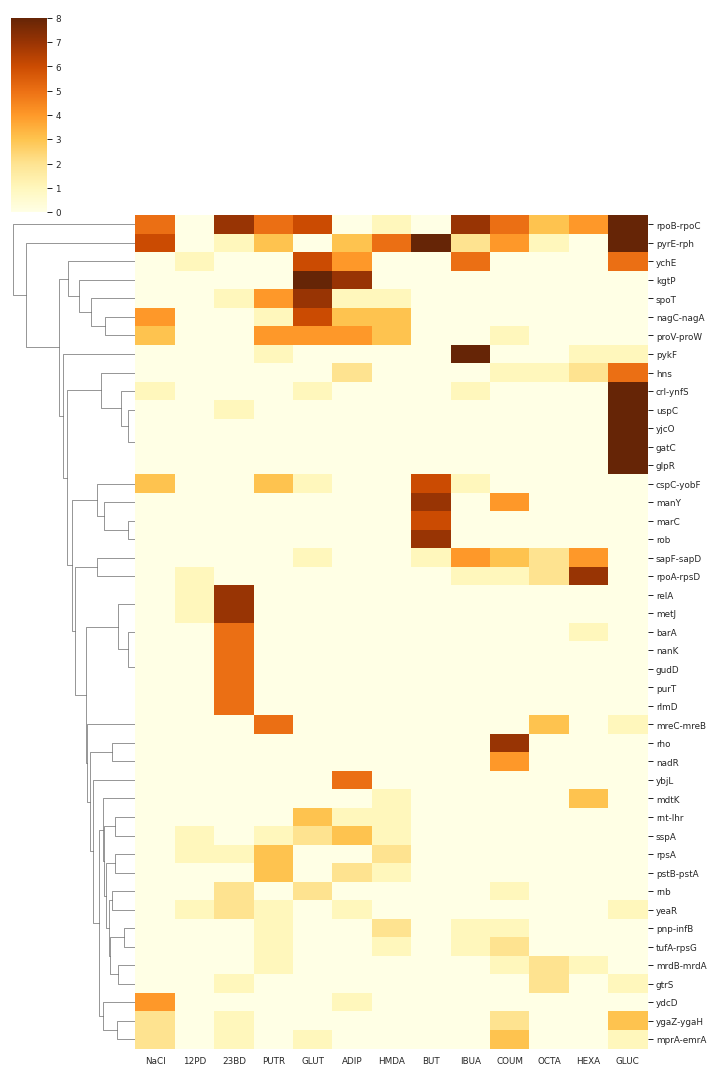

In [64]:
ax = sns.clustermap(group_mut_table, 
                    cmap="YlOrBr",
                   col_cluster=False,
                   #vmax=5,
                    figsize=(10, 15))

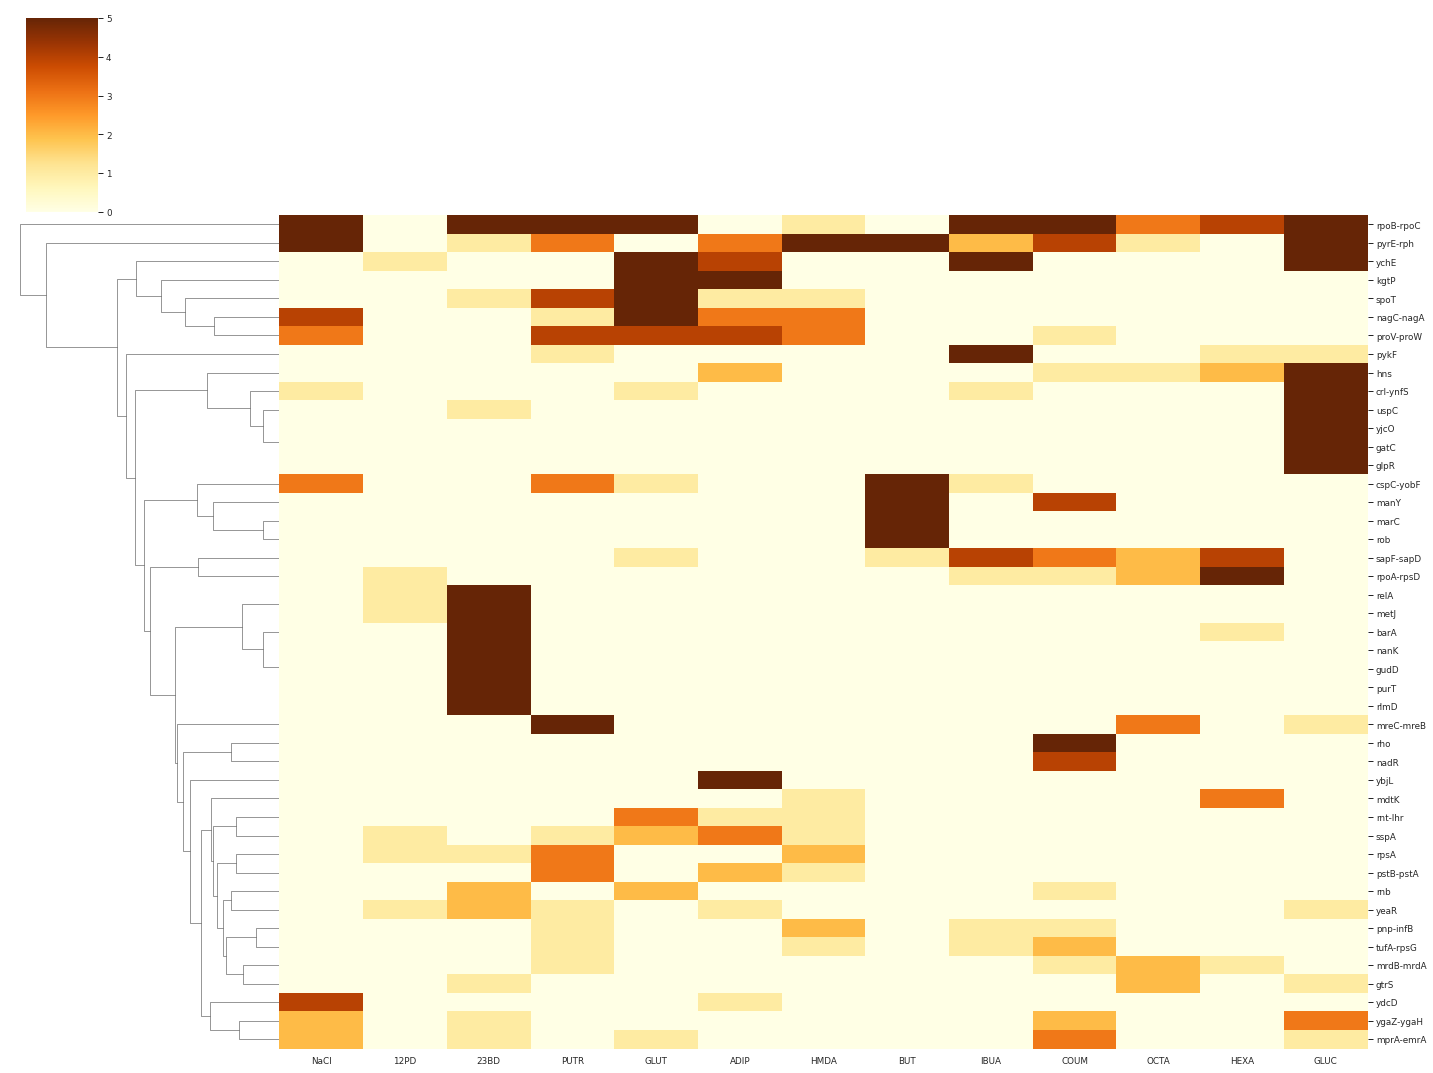

In [65]:
ax = sns.clustermap(group_mut_table, 
                    cmap="YlOrBr",
                   col_cluster=False,
                   vmax=5,
                    figsize=(20, 15))

In [66]:
# Show heatmap with ratios
group_mut_table_fraction = pd.DataFrame()

In [67]:
for chem in group_mut_table.columns:
    group_mut_table_fraction[chem] = group_mut_table[chem]/int(condition[condition['compound']==chem].compound.value_counts())

In [68]:
#Current order
"""

final_conc = {
    '12PD':1.09081351,
    '23BD':0.876599239,
    'HMDA':0.653988469,
    'PUTR':0.862166761,
    'GLUT':1.078564941,
    'ADIP':1.026413029,
    'HEXA':0.129132231,
    'OCTA':0.138686638,
    'COUM':0.243664717,
    'IBUA':0.286993457,
    'BUT':0.218623482,
    'NaCl':1.72,
    'GLUC':0
}

final_conc=pd.DataFrame(pd.Series(final_conc))
final_conc=final_conc.rename(columns={0:'conc'})
final_conc=final_conc.reindex(['NaCl', '12PD', '23BD', 'PUTR', 'GLUT', 'ADIP', 'HMDA', 'BUT', 'IBUA',
       'COUM', 'OCTA', 'HEXA', 'GLUC'])

final_conc
"""

"\n\nfinal_conc = {\n    '12PD':1.09081351,\n    '23BD':0.876599239,\n    'HMDA':0.653988469,\n    'PUTR':0.862166761,\n    'GLUT':1.078564941,\n    'ADIP':1.026413029,\n    'HEXA':0.129132231,\n    'OCTA':0.138686638,\n    'COUM':0.243664717,\n    'IBUA':0.286993457,\n    'BUT':0.218623482,\n    'NaCl':1.72,\n    'GLUC':0\n}\n\nfinal_conc=pd.DataFrame(pd.Series(final_conc))\nfinal_conc=final_conc.rename(columns={0:'conc'})\nfinal_conc=final_conc.reindex(['NaCl', '12PD', '23BD', 'PUTR', 'GLUT', 'ADIP', 'HMDA', 'BUT', 'IBUA',\n       'COUM', 'OCTA', 'HEXA', 'GLUC'])\n\nfinal_conc\n"

In [69]:
final_conc = {
    '12PD':1.09081351,
    '23BD':0.876599239,
    'HMDA':0.653988469,
    'PUTR':0.862166761,
    'GLUT':1.078564941,
    'ADIP':1.026413029,
    'HEXA':0.129132231,
    'OCTA':0.138686638,
    'COUM':0.243664717,
    'IBUA':0.286993457,
    'BUT':0.218623482,
    'NaCl':1.72,
    'GLUC':0
}

final_conc=pd.DataFrame(pd.Series(final_conc))
final_conc=final_conc.rename(columns={0:'conc'})

final_conc=final_conc.sort_values(by='conc', ascending=False) ##Re order by the final osmolarities
final_conc.index

Index(['NaCl', '12PD', 'GLUT', 'ADIP', '23BD', 'PUTR', 'HMDA', 'IBUA', 'COUM',
       'BUT', 'OCTA', 'HEXA', 'GLUC'],
      dtype='object')

In [70]:
# The order given is what ultimately ends up in the figure
group_mut_table_fraction.columns
#group_mut_table_fraction = group_mut_table_fraction[['NaCl', '12PD', '23BD', 'PUTR', 'GLUT', 'ADIP', 'HMDA', 'BUT', 'IBUA',   'COUM', 'OCTA', 'HEXA', 'GLUC']]
group_mut_table_fraction = group_mut_table_fraction[final_conc.index]
#group_mut_table_fraction

In [71]:
group_mut_table_fraction.head(2)

,NaCl,12PD,GLUT,ADIP,23BD,PUTR,HMDA,IBUA,COUM,BUT,OCTA,HEXA,GLUC
crl-ynfS,0.166667,0.0,0.125,0.0,0.0,0.000000,0.0,0.125,0.000,0.0,0.000000,0.000000,1.0
mrdB-mrdA,0.000000,0.0,0.000,0.0,0.0,0.142857,0.0,0.000,0.125,0.0,0.333333,0.142857,0.0


In [72]:
#group_mut_table_fraction.to_csv("./mutation_frequency_fraction.csv")

In [73]:
mut_feat_sum_df = group_mut_table.copy()
mut_feat_sum_df = mut_feat_sum_df.astype(int)
mut_feat_sum_df['sum'] = mut_feat_sum_df.sum(axis=1)
mut_feat_sum_df = mut_feat_sum_df[['sum']]
mut_feat_sum_df.head()

,sum
crl-ynfS,11
mrdB-mrdA,5
nagC-nagA,17
ybjL,5
rpsA,7


In [74]:
palette = sns.color_palette()
col_col = {
    '12PD':palette[0], #diols
    '23BD':palette[0],
    'HMDA':palette[1], #diamines
    'PUTR':palette[1],
    'GLUT':palette[2],
    'ADIP':palette[2],
    'HEXA':palette[3],
    'OCTA':palette[3],
    'COUM':palette[4],
    'IBUA':palette[4],
    'BUT':palette[4],
    'NaCl':palette[5],
    'GLUC':palette[6]
}
col_col=pd.Series(col_col)
col_col=col_col.reindex(final_conc.index)

Text(0.4, 0.92, 'Common mutations identified in evolved isolates')

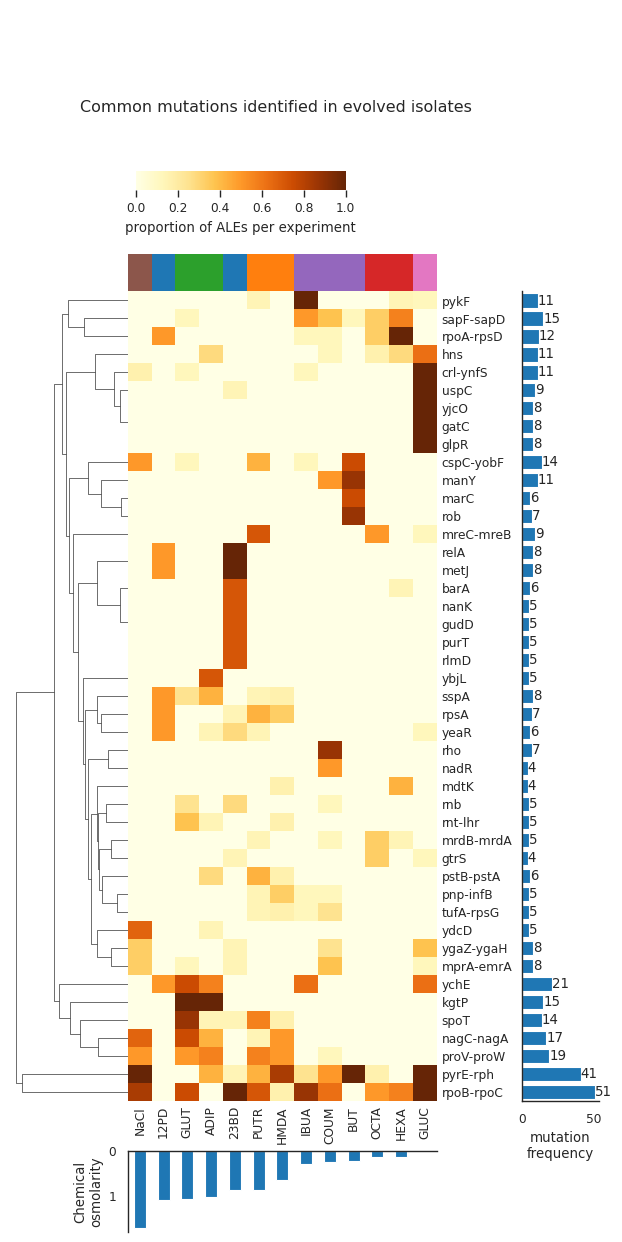

In [89]:
plt.rcParams["figure.dpi"] = 100
from mpl_toolkits.axes_grid1 import make_axes_locatable

cm = sns.clustermap(
    group_mut_table_fraction,
    cmap="YlOrBr",
    col_cluster=False,
#    figsize=(5, 10.25),
        figsize=(7, 13),
    cbar_kws={'label': 'proportion of ALEs per experiment', 'orientation':'horizontal'},
    cbar_pos=(0.2, 0.85, 0.3, 0.015),
    col_colors=[col_col]

#    dendrogram_ratio=0.1
)
cm.ax_heatmap.tick_params(axis='both', which='both', length=0)


barplot_padding = 0.85
osmo_barplot_padding = 0.5

heatmap_space = make_axes_locatable(cm.ax_heatmap)
mut_cnt_ax = heatmap_space.append_axes("right", size="25%", pad=barplot_padding)
col_colors_space = make_axes_locatable(cm.ax_col_colors)
nax_col_clrs = col_colors_space.new_horizontal(size="25%", pad=barplot_padding)

osmolarity_ax = heatmap_space.append_axes("bottom", size="10%", pad=osmo_barplot_padding)
row_dendo_space = make_axes_locatable(cm.ax_row_dendrogram)
# nax_osmolarity = row_dendo_space.new_vertical(size="10%", pad=osmo_barplot_padding)
nay = row_dendo_space.new_vertical(size="10%", pad=osmo_barplot_padding, pack_start=True)  # pack_start describes on what end the dendogram padding is applied


# Sort the values for the bar plot to have the same order as clusters
cm_y_tick_order = [t.get_text() for t in np.array(cm.ax_heatmap.get_yticklabels())]
mut_feat_sum_df = mut_feat_sum_df.reindex(cm_y_tick_order)
ax = mut_feat_sum_df.plot.barh(rot=0, stacked=True, ax=mut_cnt_ax, width=0.8)
ax.bar_label(ax.containers[0])
mut_cnt_ax.spines['top'].set_visible(False)
mut_cnt_ax.spines['right'].set_visible(False)
mut_cnt_ax.set_ylim(-0.5,len(group_mut_table_fraction.index)-0.5)  # needed to align bar-plots with clustermap residues
mut_cnt_ax.set_yticklabels([])
mut_cnt_ax.invert_yaxis()
mut_cnt_ax.set_xlabel("mutation\nfrequency")
mut_cnt_ax.get_legend().remove()



#Add one more bar 

cm_x_tick_order = [t.get_text() for t in np.array(cm.ax_heatmap.get_xticklabels())]
final_conc=final_conc.reindex(cm_x_tick_order)
ax2 = final_conc.plot.bar(rot=0, stacked=True, ax=osmolarity_ax)
osmolarity_ax.invert_yaxis()
osmolarity_ax.spines['bottom'].set_visible(False)
osmolarity_ax.spines['right'].set_visible(False)
osmolarity_ax.set_ylabel("Chemical\nosmolarity")
osmolarity_ax.get_legend().remove()
osmolarity_ax.xaxis.set_visible(False)


col=cm.ax_col_dendrogram.get_position()
#cm.ax_col_dendrogram.set_position([col.x0, col.y0, col.width*0.75, col.height*0.2])

col2=cm.ax_row_dendrogram.get_position()

#cm.ax_row_dendrogram.set_position([col2.x0, 0.17, col2.x1, col2.y1])


cm.fig.suptitle("Common mutations identified in evolved isolates",
                y=0.92,
                x=0.4
               )

In [76]:
cm.savefig('../Plots/Figure2.svg')

In [77]:
#Remove mutations if observed in the glucose condition

In [78]:
gluc_genes = group_mut_table_fraction[group_mut_table_fraction.GLUC!=0].index
group_mut_table_fraction_woGlc=group_mut_table_fraction.drop(index=gluc_genes)
group_mut_table_fraction_woGlc=group_mut_table_fraction_woGlc.drop(columns={'GLUC'})
mut_feat_sum_df_woGlc=mut_feat_sum_df.drop(index=gluc_genes)
final_conc_woGlc=final_conc.drop('GLUC')

Text(0.4, 0.92, 'Common mutations identified in evolved isolates')

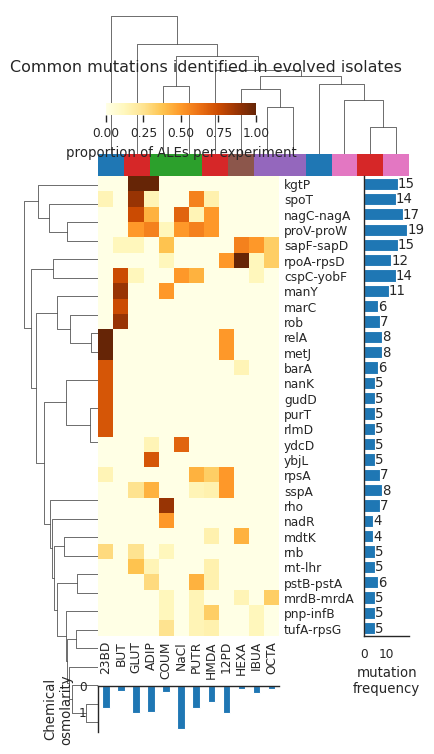

In [79]:
# group_mut_table
plt.rcParams["figure.dpi"] = 100
from mpl_toolkits.axes_grid1 import make_axes_locatable

cm = sns.clustermap(
    group_mut_table_fraction_woGlc,
    cmap="YlOrBr",
    col_cluster=True,
#    figsize=(5, 10.25),
        figsize=(5, 8),
    cbar_kws={'label': 'proportion of ALEs per experiment', 'orientation':'horizontal'},
#    cbar_pos=(0.2, 0.95, 0.3, 0.015),
    cbar_pos=(0.2, 0.85, 0.3, 0.015),
    col_colors=[col_col]

#    dendrogram_ratio=0.1
)
cm.ax_heatmap.tick_params(axis='both', which='both', length=0)


barplot_padding = 0.85
osmo_barplot_padding = 0.5

heatmap_space = make_axes_locatable(cm.ax_heatmap)
mut_cnt_ax = heatmap_space.append_axes("right", size="25%", pad=barplot_padding)
osmolarity_ax = heatmap_space.append_axes("bottom", size="10%", pad=osmo_barplot_padding)


# Sort the values for the bar plot to have the same order as clusters
cm_y_tick_order = [t.get_text() for t in np.array(cm.ax_heatmap.get_yticklabels())]
mut_feat_sum_df_woGlc = mut_feat_sum_df_woGlc.reindex(cm_y_tick_order)
ax = mut_feat_sum_df_woGlc.plot.barh(rot=0, stacked=True, ax=mut_cnt_ax, width=0.8)
ax.bar_label(ax.containers[0])
mut_cnt_ax.spines['top'].set_visible(False)
mut_cnt_ax.spines['right'].set_visible(False)
mut_cnt_ax.set_ylim(-0.5,len(group_mut_table_fraction_woGlc.index)-0.5)  # needed to align bar-plots with clustermap residues
mut_cnt_ax.set_yticklabels([])
mut_cnt_ax.invert_yaxis()
mut_cnt_ax.set_xlabel("mutation\nfrequency")
mut_cnt_ax.get_legend().remove()



#Add one more bar 

cm_x_tick_order = [t.get_text() for t in np.array(cm.ax_heatmap.get_xticklabels())]
final_conc_woGlc=final_conc_woGlc.reindex(cm_x_tick_order)
ax2 = final_conc_woGlc.plot.bar(rot=0, stacked=True, ax=osmolarity_ax)
osmolarity_ax.invert_yaxis()
osmolarity_ax.spines['bottom'].set_visible(False)
osmolarity_ax.spines['right'].set_visible(False)
osmolarity_ax.set_ylabel("Chemical\nosmolarity")
osmolarity_ax.get_legend().remove()
osmolarity_ax.xaxis.set_visible(False)


col=cm.ax_col_dendrogram.get_position()
#cm.ax_col_dendrogram.set_position([col.x0, col.y0, col.width*0.75, col.height*0.2])

col2=cm.ax_row_dendrogram.get_position()

#cm.ax_row_dendrogram.set_position([col2.x0, 0.17, col2.x1, col2.y1])


cm.fig.suptitle("Common mutations identified in evolved isolates",
                y=0.92,
                x=0.4
               )

In [351]:
cm.savefig('../Plots/Figure2_noGlc.svg')

In [354]:
cm.savefig('../Plots/Figure2_noGlc_row_cluster.svg')

In [459]:
COG = pd.DataFrame(index=group_mut_table_fraction.index, columns={'gene_name','COG','locus_tag','gene_product'})

In [478]:
for i in COG.index:
    #print()
    new_name=i.split('-')[0]
    COG.loc[i,'gene_name']=new_name
    COG.loc[i,'COG']=gene_table[gene_table.gene_name==new_name].COG.values[0]
    COG.loc[i,'gene_product']=gene_table[gene_table.gene_name==new_name].gene_product.values[0]
    

In [479]:
i

'rob'

In [480]:
COG

,gene_name,COG,locus_tag,gene_product
crl-ynfS,crl,No COG annotation,NaN,RNA polymerase holoenzyme assembly factor Crl
mrdB-mrdA,mrdB,Cell wall/membrane/envelope biogenesis,NaN,SEDS family protein MrdB
nagC-nagA,nagC,Transcription,NaN,DNA-binding transcriptional dual regulator NagC
ybjL,ybjL,Inorganic ion transport and metabolism,NaN,putative transport protein YbjL
rpsA,rpsA,"Translation, ribosomal structure and biogenesis",NaN,30S ribosomal subunit protein S1
hns,hns,Transcription,NaN,DNA-binding transcriptional dual regulator H-NS
ychE,ychE,"Intracellular trafficking, secretion, and vesi...",NaN,MarC family putative inner membrane protein YchE
rnb,rnb,"Translation, ribosomal structure and biogenesis",NaN,RNase II
sapF-sapD,sapF,Inorganic ion transport and metabolism,NaN,putrescine ABC exporter ATP binding protein SapF
ydcD,ydcD,No COG annotation,NaN,uncharacterized protein YdcD


In [481]:
COG['curated']=COG['COG']

In [482]:
import plotly.express as px

In [483]:
COG_data=pd.DataFrame(COG.curated.value_counts())
px.pie(COG_data,values='curated', names=COG_data.index)

In [485]:
#Chemical tol only

In [ ]:
gluc_genes = group_mut_table_fraction[group_mut_table_fraction.GLUC!=0].index
group_mut_table_fraction_woGlc=group_mut_table_fraction.drop(index=gluc_genes)
group_mut_table_fraction_woGlc=group_mut_table_fraction_woGlc.drop(columns={'GLUC'})
mut_feat_sum_df_woGlc=mut_feat_sum_df.drop(index=gluc_genes)
final_conc_woGlc=final_conc.drop('GLUC')

In [495]:
group_mut_table_fraction_woGlcNaCl=group_mut_table_fraction.drop(columns={'GLUC','NaCl'})
to_del=group_mut_table_fraction_woGlcNaCl[group_mut_table_fraction_woGlcNaCl.sum(axis=1)==0].index
group_mut_table_fraction_woGlcNaCl=group_mut_table_fraction_woGlcNaCl.drop(index=to_del)